### 0 - Imports

In [1]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['font.size'] = 10
plt.rcParams.update({
    # 'text.usetex': True,
    'font.family': 'serif',
})

# Custom scripts
from scripts.dataset_io import getDatasetFilePath, getDataset

### 1 - Globals

In [2]:
dataDir: str = '../data'
countryName: str = 'Portugal'

settings: 'dict[str, any]' = {
	'filePath': getDatasetFilePath(
		dataDir, 
		countryName, 
		fallback='CPITimeSeries'
	),
	'countryName': countryName,
	'indicator': 'PCPI_IX',
}

In [3]:
def tsPlot(tsList, title, xlabel, ylabel, legend = None) -> None:
	for ts in tsList:
		plt.plot(ts)
	if legend: plt.legend(legend)
	plt.title(title)
	plt.ylabel(ylabel)
	plt.xlabel(xlabel)
	plt.show()

### 2 - Extract relevant info + Data Understanding

In [4]:
def understandData(df: pd.DataFrame) -> None :
  print('DATAFRAME INFO')
  print('------')
  print('df shape:', df.shape)
  print('------')
  print('df head: \n', df.head())
  print('------')
  print('df dtypes:\n', df.dtypes)
  print('------')
  print('df describe: \n', df.describe())
  print('------')
  print('df info: \n', df.info())

In [5]:
df: pd.DataFrame = getDataset(dataDir, settings)

Reading from ../data/Portugal.pkl ...
Done!


In [6]:
understandData(df)

DATAFRAME INFO
------
df shape: (392, 3)
------
df head: 
          cpi  year  month
0  42.431999  1990      1
1  43.377998  1990      2
2  43.632000  1990      3
3  44.134998  1990      4
4  44.603001  1990      5
------
df dtypes:
 cpi      float32
year       int16
month       int8
dtype: object
------
df describe: 
               cpi         year       month
count  392.000000   392.000000  392.000000
mean    84.125526  2005.836735    6.459184
std     17.846661     9.443539    3.448320
min     42.431999  1990.000000    1.000000
25%     69.122252  1998.000000    3.000000
50%     88.884003  2006.000000    6.000000
75%    100.434250  2014.000000    9.000000
max    114.554001  2022.000000   12.000000
------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cpi     392 non-null    float32
 1   year    392 non-null    int16  
 2   month   392 non-null    int8

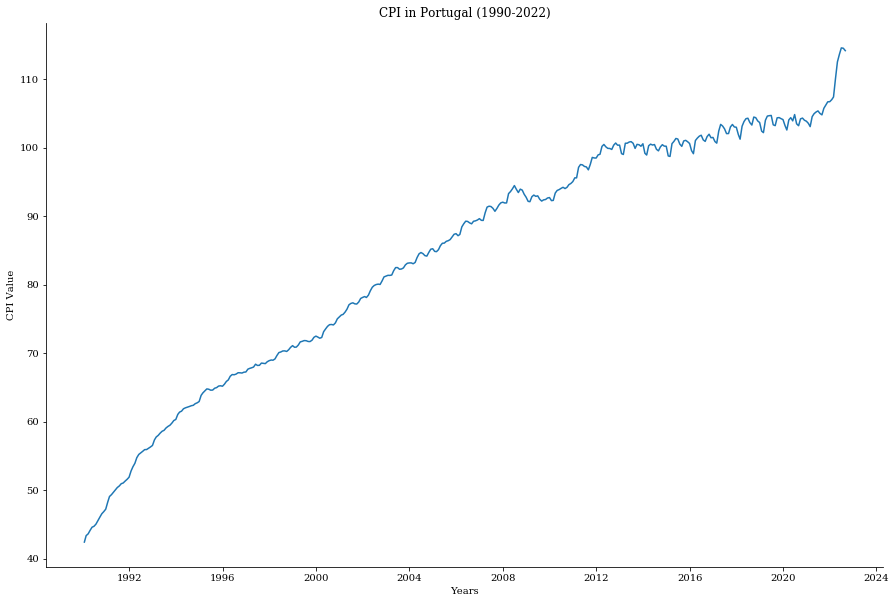

In [7]:
# Convert DataFrame to Time Series
ts: np.ndarray = df['cpi'].to_numpy()
ts: pd.Series = pd.Series(
	ts, 
	index=pd.date_range('1-1-1990', periods=len(ts), freq='M'),
	name='CPI'
)

tsPlot(
	[ts],
	title='CPI in Portugal (1990-2022)', 
	xlabel='Years', 
	ylabel='CPI Value'
)

### 3 - Data Splitting

In [8]:
# Split data - a 60%-40% split (mostly random values, 
# but we wanted to fit the model using old and more recent 
# data that included data after the Global Financial Crisis of 2008)
def splitDataset(ts, trainSize = 0.60) -> 'tuple(pd.Series, pd.Series)':
	cutoffPoint: int = round(trainSize * len(ts))
	return (ts[:cutoffPoint], ts[cutoffPoint:])

In [9]:
tsTrain, tsTest = splitDataset(ts)

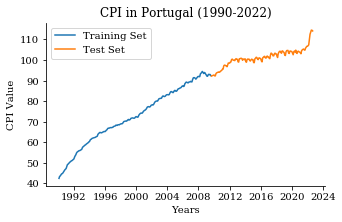

In [128]:
plt.rcParams['figure.figsize'] = (5, 3)

tsPlot(
	[tsTrain, tsTest], 
	title='CPI in Portugal (1990-2022)', 
	xlabel='Years', 
	ylabel='CPI Value',
	legend=['Training Set', 'Test Set']
)

### 4 - Basic Description Techniques & Transformations

At first glance, the plots suggest a multiplicative 
model fits the data better, i.e

$\\x(n)=tr(n)sn(n)e(n).$

We can see the seasonality and erratic components changing 
(in our case, increasing) with the trend. We expect a more
stable plot upon detrending the TS, when assuming a
multiplicative model (compared to an additive one).

#### 4.1 - Trend

In [11]:
def calculateMSE(ts: pd.Series, fittedTs: pd.Series) -> float:
	absError: pd.Series = fittedTs - ts
	return np.mean(np.square(absError))


##### I - Polinomial Fitting

In [12]:
x = np.arange(len(tsTrain))

In [13]:
# Assuming a linear trend
linearCoefs = np.polyfit(x, tsTrain, 1)
linearValues = np.polyval(linearCoefs, x)
linearTs = pd.Series(
	data=linearValues,
	index=tsTrain.index
)

In [14]:
# Assuming a quadratic trend
quadCoefs = np.polyfit(x, tsTrain, 2)
quadValues = np.polyval(quadCoefs, x)
quadTs = pd.Series(
	data=quadValues,
	index=tsTrain.index
)

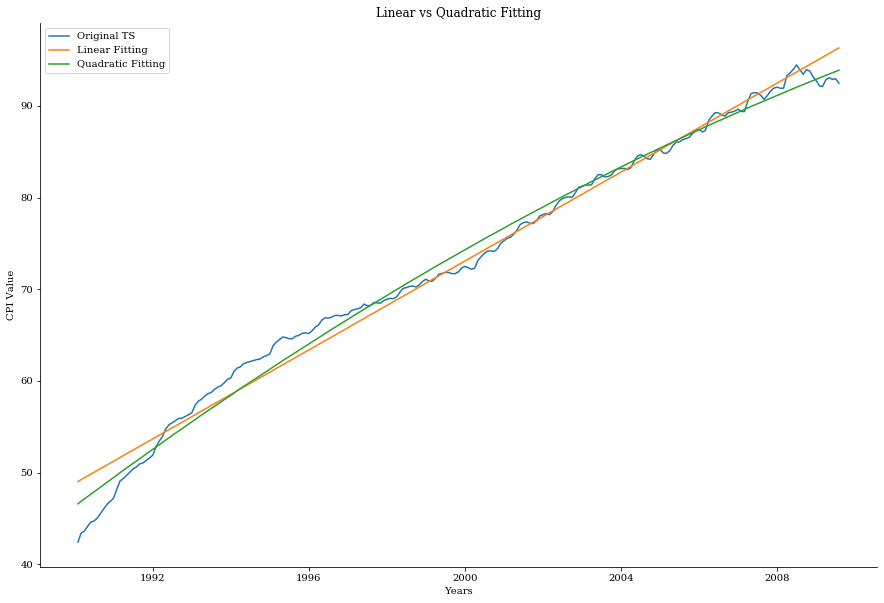

In [15]:
tsPlot(
	[tsTrain, linearTs, quadTs], 
	title='Linear vs Quadratic Fitting',
	xlabel='Years',
	ylabel='CPI Value',
	legend=['Original TS', 'Linear Fitting', 'Quadratic Fitting']
)

##### Additive vs Multiplicative

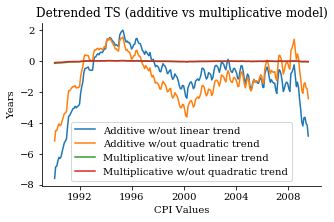

In [129]:
plt.rcParams['figure.figsize'] = (5, 3)

# Removing trends
linearTsDetrendedAdd = tsTrain - linearTs
quadTsDetrendedAdd = tsTrain - quadTs

# Removing polinomial trends
linearTsDetrendedMult = tsTrain/linearTs
quadTsDetrendedMult = tsTrain/quadTs

tsPlot(
	[linearTsDetrendedAdd - 1, quadTsDetrendedAdd - 1,
	linearTsDetrendedMult - 1, quadTsDetrendedMult - 1],
	title='Detrended TS (additive vs multiplicative model)',
	xlabel='CPI Values',
	ylabel='Years',
	legend=[
		'Additive w/out linear trend', 
		'Additive w/out quadratic trend',
		'Multiplicative w/out linear trend', 
		'Multiplicative w/out quadratic trend',
	]
)

##### II - Moving Average

In [18]:
# 'm': number of samples used
# to calculate the average
# for each window
def maFiltering(ts, m, dataAug = True) -> pd.Series:
	w = np.ones(m) * (1 / float(m))
	lag: int = int(np.floor((m - 1) / 2))
	if dataAug:
		# Artificially add data to compensate
		# for the samples lost in the calculation
		# of the mean with a window of M samples
		tsAug = np.flip(ts[:lag]) \
			.append(ts.append(np.flip(ts[-lag:])))
	else: tsAug = ts

	nf: range = range(lag, tsAug.size - lag)
	xf = np.zeros(tsAug.size - 2 * lag).astype('float')

	for n in nf:
		xf[n - lag] = (1 / float(sum(w))) * np.sum(np.multiply(tsAug[n - lag: n + lag + 1], w))

	return pd.Series(
		data=xf, 
		index=tsAug.index[lag: tsAug.size - lag]
	)

In [19]:
mValues: 'list[int]' = [7, 13]
maSeries: 'list[pd.Series]' = [ maFiltering(tsTrain, m) for m in mValues ]
maLegend: 'list[str]' = [ f'MA w/ M = {m}' for m in mValues ]

In [20]:
# Detrend TS with M = 13 and with M = 7
maTs7: pd.Series = maSeries[0]
maTs13: pd.Series = maSeries[1]
maTsDetrended13 = tsTrain/maTs13
maTsDetrended7 = tsTrain/maTs7

##### III - LOWESS

In [22]:
import statsmodels.api as sm
from scipy.optimize import curve_fit

In [23]:
def linearFunction(x, a, b):
	return a * x + b

def xWeights(x, xi, span):
    return (1 - abs((x - xi) / float(span)) ** 3) ** 3

def yWeights(ri, MAD):
  if np.abs(ri) >= 6 * MAD:  return 0
  return (1 - ((ri / (6 * MAD)) ** 2)) ** 2

def loessPass(ts, span, tsE=pd.Series(np.array([])), timePass=True):
    lag= int((span - 1) / 2)
    xf= np.zeros(ts.size).astype('float')
    for k in range(ts.size):
        if k <= lag:
            win= ts[0: span]
            if not timePass:
                winE= tsE[0: span]
            xvs = np.array(range(span))
        elif k>ts.size-lag:
            win= ts[ts.size-span: ts.size]
            if not timePass:
                winE= tsE[tsE.size - span: tsE.size]
            xvs= np.array(range(ts.size - span, ts.size))
        else:
            win=ts[k-lag-1:k+lag]
            if not timePass:
                winE= tsE[k - lag - 1: k + lag]
            xvs= np.array(range(k-lag, k + lag + 1))

        ws= np.zeros(span).astype('float')
            
        if not timePass:
            res= np.array(win-winE)
            MAD= np.median(np.abs(res))
            
        for xw in range(len(xvs)):
            if timePass:
                ws[xw]=xWeights(
                    k, xvs[xw], 
                    np.max(
                        (np.abs(k-xvs[0]),
                        np.abs(k-xvs[-1]))
                    )
                )
            else:
                ws[xw] = yWeights(res[xw], MAD)
        exog = sm.add_constant(xvs)
        
        
        mod_wls = sm.WLS(win, exog, weights=ws)
        res_wls = mod_wls.fit()
        
        xf[k] = res_wls.params[1] * k + res_wls.params[0]
    return xf

def lowess(ts, span, ftype='linear'):
    xf= loessPass(ts, span=span, timePass=True)
    xf= loessPass(ts, tsE=pd.Series(data=xf, index=ts.index), span=span, timePass=False)
    xf= pd.Series(data=xf, index=ts.index)
    return xf

In [24]:
lowessSeries: 'list[pd.Series]' = [ lowess(tsTrain, span=m) for m in mValues ]
lowessLegend: 'list[str]' = [ f'LOWESS w/ M = {m}' for m in mValues ]

In [70]:
# Detrend TS with M = 13 and with M = 7
lowessTs7: pd.Series = lowessSeries[0]
lowessTs13: pd.Series = lowessSeries[1]
lowessTsDetrended13 = tsTrain/lowessTs13
lowessTsDetrended7 = tsTrain/lowessTs7

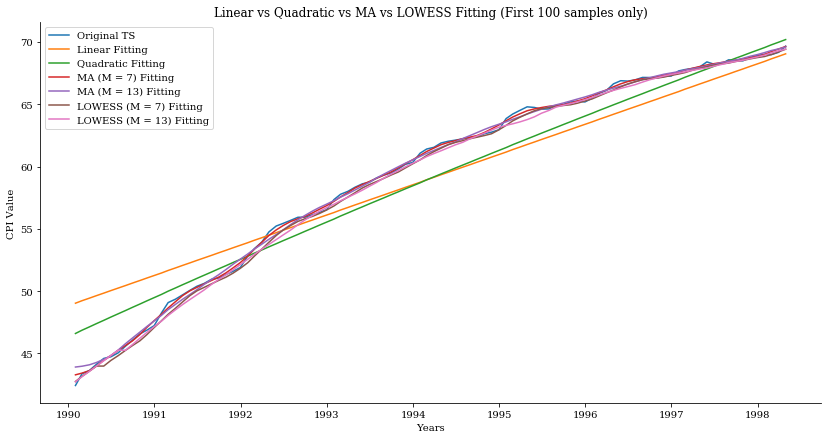

In [71]:
plt.rcParams['figure.figsize'] = (14, 7)

tsPlot(
	[
		tsTrain[:100], 
		linearTs[:100], 
		quadTs[:100], 
		maTs7[:100], 
		maTs13[:100], 
		lowessTs7[:100], 
		lowessTs13[:100]
	], 
	title='Linear vs Quadratic vs MA vs LOWESS Fitting (First 100 samples only)',
	xlabel='Years',
	ylabel='CPI Value',
	legend=[
		'Original TS', 
		'Linear Fitting', 
		'Quadratic Fitting',
		'MA (M = 7) Fitting',
		'MA (M = 13) Fitting',
		'LOWESS (M = 7) Fitting',
		'LOWESS (M = 13) Fitting',
	]
)

With the plot above, we can see that the smoothing based approaches fit the data much better. With that said, we will discard linear and quadratic fitting.

If we look at the raw time series plot, we can detect a big cycle that has a periodicity of about a year. Through a more careful observation, however, we can identify another (shorter) pattern, with a periodicity of ~6 months, albeit more unstable.
So it is logical to detrend the TS based on these assumptions and compare both of them.

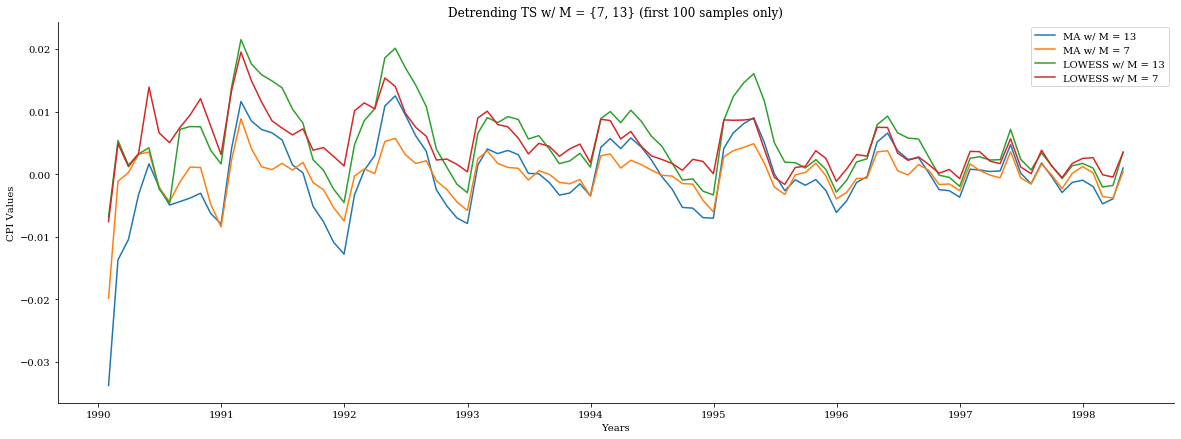

In [75]:
plt.rcParams['figure.figsize'] = (20, 7)

tsPlot(
	[
		maTsDetrended13[:100] - 1, 
		maTsDetrended7[:100] - 1, 
		lowessTsDetrended13[:100] - 1, 
		lowessTsDetrended7[:100] - 1
	],
	title='Detrending TS w/ M = {7, 13} (first 100 samples only)',
	xlabel='Years',
	ylabel='CPI Values',
	legend=[
		'MA w/ M = 13',
		'MA w/ M = 7',
		'LOWESS w/ M = 13',
		'LOWESS w/ M = 7',
	]
)

In [76]:
detrendedSeries: list = [
	linearTsDetrendedMult, 
	quadTsDetrendedMult, 
	maTsDetrended13,
	maTsDetrended7,
	lowessTsDetrended13,
	lowessTsDetrended7
]
mse: 'list[float]' = [ np.mean((dts - 1) ** 2)  for dts in detrendedSeries ]
mae: 'list[float]' = [ np.mean(np.abs(dts - 1)) for dts in detrendedSeries ]

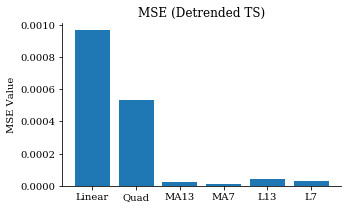

In [143]:
plt.rcParams['figure.figsize'] = (5, 3)

plt.bar(
	[
		'Linear', 'Quad', 
		'MA13', 
		'MA7', 
		'L13', 
		'L7',
	], mse
)
plt.ylabel('MSE Value')
plt.title('MSE (Detrended TS)')
plt.show()

#### 4.2 - Seasonality

##### I - DFT

In [79]:
def getFrequencies(ts, fs = 12):
	# Mean was subtracted because we want to
	# evaluate the importance of non-null frequency components
	dft = (np.abs(np.fft.rfft(ts - ts.mean())) ** 2 / ts.size)
	freq = np.fft.rfftfreq(ts.size, d=1/fs)
	return dft, freq

In [82]:
dftFreq: 'list[tuple]' = []
for dts in detrendedSeries[2:]:
	dft, freq = getFrequencies(dts)
	dftFreq += [(dft, freq)]

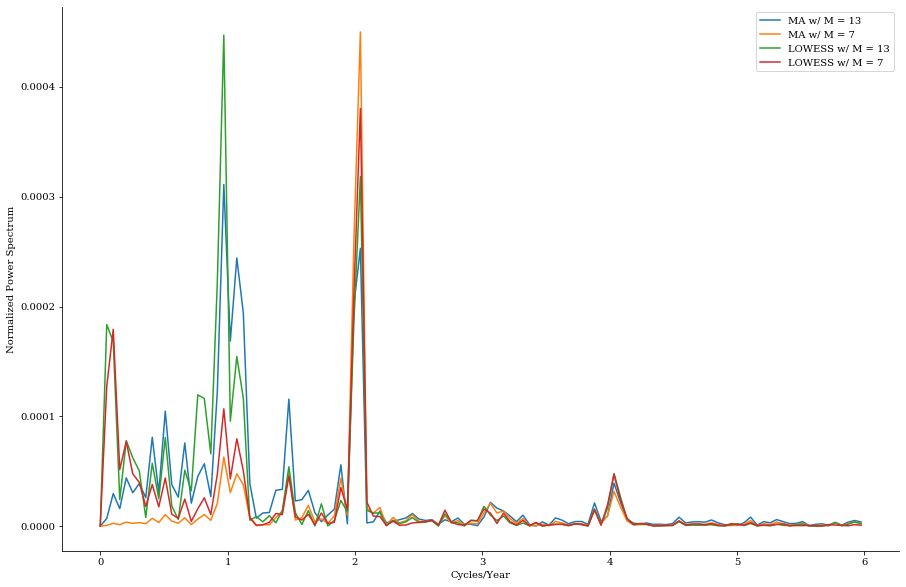

In [83]:
plt.rcParams['figure.figsize'] = (15, 10)
plt.figure()
for pair in dftFreq:
	dft, freq = pair
	plt.plot(freq, dft)
	plt.xlabel('Cycles/Year')
	plt.ylabel('Normalized Power Spectrum')
plt.legend([
	'MA w/ M = 13', 
	'MA w/ M = 7', 
	'LOWESS w/ M = 13',
	'LOWESS w/ M = 7',
])
plt.show()

There appears to be a moderate amount of noise on frequencies below ~0.000175

In [84]:
def removeNoise(ft, threshold = 0.0002):
	return ft * (ft > threshold)

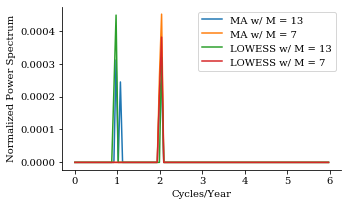

In [144]:
plt.rcParams['figure.figsize'] = (5, 3)
plt.figure()
for pair in dftFreq:
	dft, freq = pair
	plt.plot(freq, removeNoise(dft))
	plt.xlabel('Cycles/Year')
	plt.ylabel('Normalized Power Spectrum')
plt.legend([
	'MA w/ M = 13', 
	'MA w/ M = 7', 
	'LOWESS w/ M = 13',
	'LOWESS w/ M = 7',
])
plt.show()

After noise removal, we can see that both methods detect the expected patterns (annual and biannual), as well as an interesting ~0.1/0.2 Cycle/Year **[1]**. Logically, the M = 7 approaches assign more relevance to a biannual pattern.
Furthermore, we expected to obtain a 'clean' peak at the 1 cycle/year mark with all approaches, but instead got 2 peaks with MA (w/ M = 13). We hypothesise that this can be caused by recurring government subsidies, specific to the financial legislation of the country concerned, that cause an increase in consumer buying power, which in turn may alter the dynamic of the CPI for a short period of time.

**[1]** This can be explained by calculation errors in the LOWESS implementation. When the trend is not equal to 0 (i.e is not completely removed from the time series), the DFT analysis yields abnormal peaks near frequency 0.

##### II - Butterworth Filter

In [61]:
import scipy.signal as scs

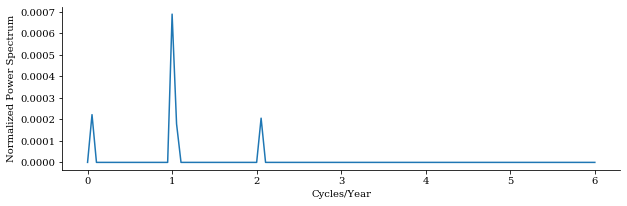

In [62]:
plt.rcParams['figure.figsize'] = (10, 3)

sos = scs.butter(
	N=5, fs=12,
	Wn=[2.4],
	output='sos'
)
seasonal_L13 = scs.sosfiltfilt(sos, lowessTsDetrended13)
dft, freq = getFrequencies(seasonal_L13)

plt.figure()
plt.plot(freq, removeNoise(dft))
plt.xlabel('Cycles/Year')
plt.ylabel('Normalized Power Spectrum')
plt.show()

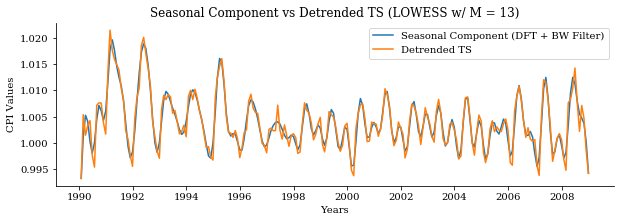

In [63]:
# Plot seasonal component
plt.figure()
tsSeasonal_L13 = pd.Series(
	data=seasonal_L13,
	index=lowessTsDetrended13.index,
)

seasonal_L7 = scs.sosfiltfilt(sos, lowessTsDetrended7)
tsSeasonal_L7 = pd.Series(
	data=seasonal_L7,
	index=lowessTsDetrended7.index,
)

seasonal_MA13 = scs.sosfiltfilt(sos, maTsDetrended13)
tsSeasonal_MA13 = pd.Series(
	data=seasonal_MA13,
	index=maTsDetrended13.index,
)

seasonal_MA7 = scs.sosfiltfilt(sos, maTsDetrended7)
tsSeasonal_MA7 = pd.Series(
	data=seasonal_MA7,
	index=maTsDetrended7.index,
)

tsPlot(
	[tsSeasonal_L13, lowessTsDetrended13],
	title='Seasonal Component vs Detrended TS (LOWESS w/ M = 13)',
	xlabel='Years',
	ylabel='CPI Values',
	legend=['Seasonal Component (DFT + BW Filter)', 'Detrended TS']
)

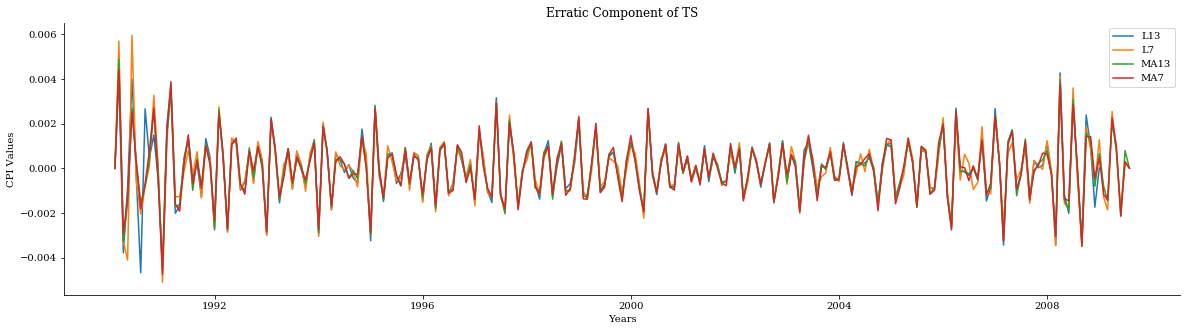

In [64]:
# Remove seasonal component, leaving the erratic component
plt.rcParams['figure.figsize'] = (20, 5)

tsErratic_L13 = lowessTsDetrended13/tsSeasonal_L13
tsErratic_L7 = lowessTsDetrended7/tsSeasonal_L7
tsErratic_MA13 = maTsDetrended13/tsSeasonal_MA13
tsErratic_MA7 = maTsDetrended7/tsSeasonal_MA7

tsPlot(
	[tsErratic_L13 - 1, tsErratic_L7 - 1, tsErratic_MA13 - 1, tsErratic_MA7 - 1],
	title='Erratic Component of TS',
	xlabel='Years',
	ylabel='CPI Values',
	legend=['L13', 'L7', 'MA13', 'MA7']
)

By removing the 3 most proeminent components of seasonality, we get a series that can be accepted as the erratic component of the TS.

##### III - Epoch Averaging

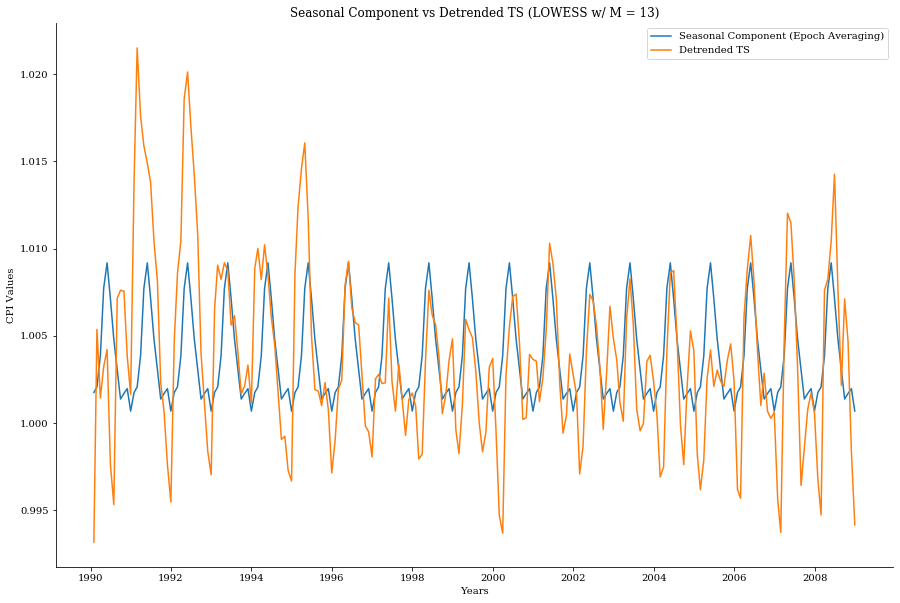

In [86]:
S = 12
N = lowessTsDetrended13[:-7].size
C = int(np.floor(N / S))

reshTs = lowessTsDetrended13[:-7].to_numpy().reshape((C, S))
ac = np.tile(np.mean(reshTs, axis=0), (C, ))
lowessTsDetrended13 = lowessTsDetrended13[:C*S]
seasonalEA = pd.Series(
	data=ac,
	index=lowessTsDetrended13.index,
)

tsPlot(
	[seasonalEA, lowessTsDetrended13],
	title='Seasonal Component vs Detrended TS (LOWESS w/ M = 13)',
	xlabel='Years',
	ylabel='CPI Values',
	legend=['Seasonal Component (Epoch Averaging)', 'Detrended TS']
)

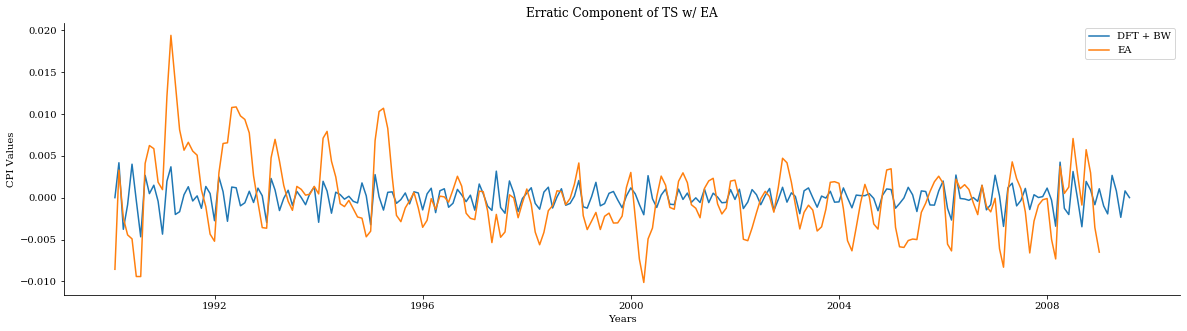

In [ ]:
# Remove seasonal component
tsErraticEA = lowessTsDetrended13/seasonalEA

tsPlot(
	[tsErratic_L13 - 1, tsErraticEA - 1],
	title='Erratic Component of TS w/ EA',
	xlabel='Years',
	ylabel='CPI Values',
	legend=['DFT + BW', 'EA']
)

As we can observe on the plot above, the erratic component extracted using Epoch Averaging fails to remove seasonality at a 6-month level - we can still detect a repeating pattern along that frequency. Since we have already established that the shorter underlying patterns are still really relevant, we can discard Epoch Averaging as a valid approach for our use-case.

#### 4.3 - Differencing

##### I - 1st-Order Differencing

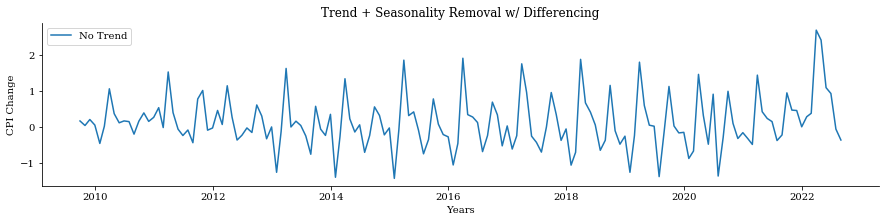

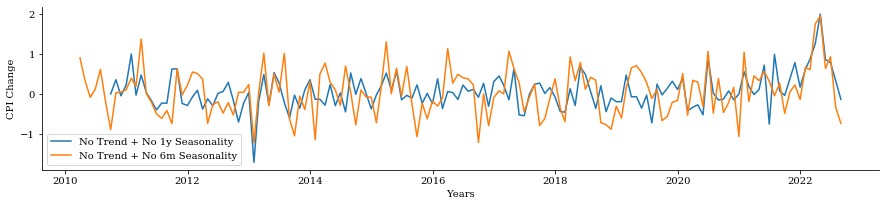

In [ ]:
plt.rcParams['figure.figsize'] = (15, 3)
tsPlot(
	[tsTest.diff()],
	title='Trend + Seasonality Removal w/ Differencing',
	xlabel='Years',
	ylabel='CPI Change',
	legend=['No Trend']
)

tsPlot(
	[tsTest.diff().diff(12), tsTest.diff().diff(6)],
	title='',
	xlabel='Years',
	ylabel='CPI Change',
	legend=['No Trend + No 1y Seasonality', 'No Trend + No 6m Seasonality']
)

In [ ]:
# Comparing erratic component extraction
# with diff(12m) vs with DFT + Butter vs EA
# -> Last 100 samples of training set only
tsPlot(
	[
		# tsTrain.diff().diff(12)[:100],
		tsErraticEA[:100] - 1,
		tsErratic_L13[:100] - 1,
	],
	title='Erratic Comp Extraction on Diff vs DFT + Butter vs EA',
	xlabel='Years',
	ylabel='CPI Values',
	legend=[
		# 'Differencing (12m)',
		'Epoch Averaging',
		'DFT + Butterworth'
	]
)

NameError: name 'tsErratic' is not defined

##### II - Autocorrelation & Correlogram

In [87]:
from scipy.stats import norm

def autocov(timeserie, T=0):
    N = timeserie.size
    mu = timeserie.mean()
    covCoef = 0
    for n in range(0, N - T - 1):
        covCoef=covCoef + (timeserie[n] - mu) * (timeserie[n+T] - mu)
    return covCoef / float(np.abs(N))
    
def autocoef(timeserie, T=0):
    return autocov(timeserie, T) / autocov(timeserie)

def correlogram(timeserie, maxT, twoside=False):
    N = timeserie.size
    if twoside:
        corrl = np.zeros(2 * maxT + 1)
        ix = np.array(range(maxT + 1))
        ix = np.concatenate((-np.flip(ix[1:]), ix), axis=0)
    else:
        corrl=np.zeros(maxT + 1)  
        ix=np.array(range(maxT + 1))
    
    for i in range(maxT + 1):
        if twoside:
            corrl[i + maxT]=autocoef(timeserie, i)
            if i > 0:
                corrl[maxT - i]=corrl[i + maxT]
        else:
            corrl[i] = autocoef(timeserie, i)
    d = {'ACS': corrl, 'upsig': np.ones(maxT+1)*(1.96 / np.sqrt(N)), 'dnsig': -np.ones(maxT + 1) * (1.96 / np.sqrt(N))}
    corrl = pd.DataFrame(data=d, index=ix)
    return corrl


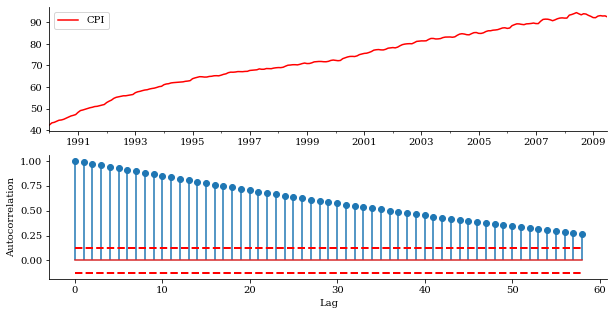

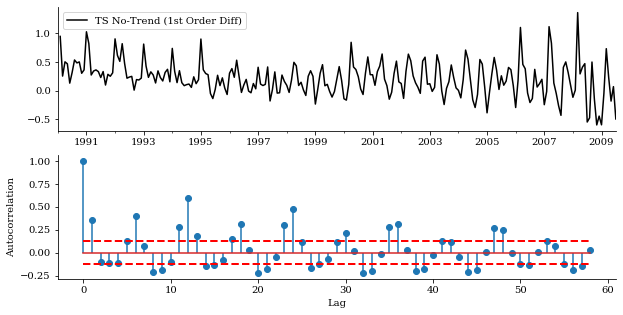

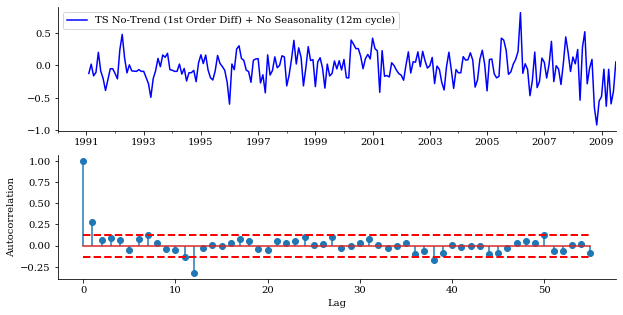

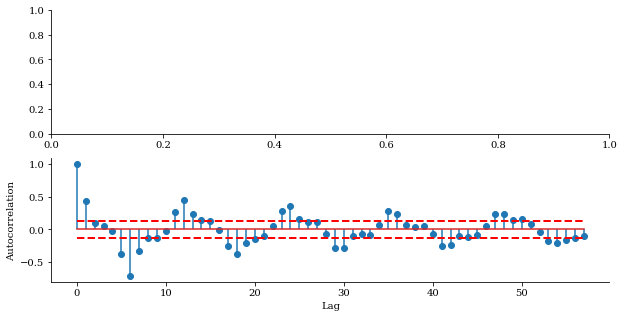

In [110]:
plt.rcParams['figure.figsize'] = (10, 5)

# Raw
fig, axs=plt.subplots(2)

tsTrain.plot(ax=axs[0],legend=True,color='r')
plt.ylabel('CPI Value')
plt.xlabel('Years')

N=tsTrain.size
corrl=correlogram(tsTrain, maxT=int(N/4))
corrl.name='Raw TS ACS'
axs[1].stem(corrl.index, corrl['ACS'], use_line_collection=True)
axs[1].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=2)
axs[1].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=2)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

# No trend-1st order diff
fig, axs=plt.subplots(2)

d1psTS = tsTrain.diff()
d1psTS.name='TS No-Trend (1st Order Diff)'
d1psTS.plot(ax=axs[0],legend=True,color='k')
plt.ylabel('CPI Value Change')
plt.xlabel('Years')

N=d1psTS.dropna().size

corrl = correlogram(d1psTS.dropna(), maxT=int(N/4))
corrl.name='CPI ACS (No trend)'
axs[1].stem(corrl.index,corrl['ACS'], use_line_collection=True)
axs[1].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=2)
axs[1].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=2)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

# No trend-1st order diff and no seasonality (seas. diff)
fig, axs=plt.subplots(2)

d1psTS = d1psTS.diff(12)
d1psTS.name = 'TS No-Trend (1st Order Diff) + No Seasonality (12m cycle)'
d1psTS.plot(ax=axs[0], legend=True, color='b')
plt.ylabel('CPI Value Change')
plt.xlabel('Years')

N=d1psTS.dropna().size

corrl = correlogram(d1psTS.dropna(), maxT=int(N/4))
corrl.name='CPI ACS (No trend + No Seasonality (12m cycle))'
axs[1].stem(corrl.index,corrl['ACS'], use_line_collection=True)
axs[1].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=2)
axs[1].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=2)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

# No trend-1st order diff and no seasonality (12m + 6m)
fig, axs=plt.subplots(2)

d1psTS = tsTrain.diff().diff(6)
d1psTS.name = 'No-trend + No 6-month cycle'
# d1psTS.plot(ax=axs[0], legend=True, color='b')
# plt.ylabel('CPI Value Change')
# plt.xlabel('Years')

N=d1psTS.dropna().size

corrl = correlogram(d1psTS.dropna(), maxT=int(N/4))
corrl.name='CPI ACS (No trend + No 6-month cycle)'
axs[1].stem(corrl.index,corrl['ACS'], use_line_collection=True)
axs[1].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=2)
axs[1].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=2)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

plt.show()

<ol>
	<li>
		As expected, the ACS plot for the raw TS demonstrates that there's a very visible long term trend (the ACS plot approximates 0 for large lags).
	</li>
	<li>
		In the 1st-order diff ACS, we can observe much more clearly the oscillations related to seasonality (around the 12-month and 6-month marks, as previously discussed). We can conclude that the ACS approach gives us a clearer insight on what seasonal patterns are present and further confirm our conclusions of multiple seasonal patterns.
		Furthermore, the plot shows us that there is a strong correlation around the 5 and 7-month marks. We can't really explain what socio-economic factors play into this phenomenon, but we hypothesize it might be related to the conclusions drawn from the DFT analysis using MA w/ W = 13, which shows a frequency peak at around the ~1.2 cycle/year mark.
	</li>
	<li>
		In the erratic component ACS extracted by removing the 12-month seasonal pattern, we can see that each sample <i>n</i> correlates negatively to the <i>n-12</i>th sample, and positively to the <i>n-1</i>th sample. In the fact, the absolute value of the <i>n-12</i>th sample's correlation outweighs the <i>n-1</i>th sample's one. This can be explained by the mere fact that there is in fact a 12-month seasonal pattern that is very much present. Furthermore, the ACS plot shows other correlations slightly above the confidence threshold (lag = {38, 50}). These are probably a result of computation errors due to small N.
		As such, we can conclude that the ACS plot indicates that this series is stationary (rapidly approximates ~0 for T>1)
	</li>
	<li>
		In the erratic component ACS extracted by removing the 6-month seasonal pattern, the negative correlation of the n-6th and n-12th samples is even more visible, which tells us that the approach used did not result in a stationary series. As such, we conclude that the erratic component extracted by removing the 12-month seasonal pattern is more representative.
	</li>
</ol>

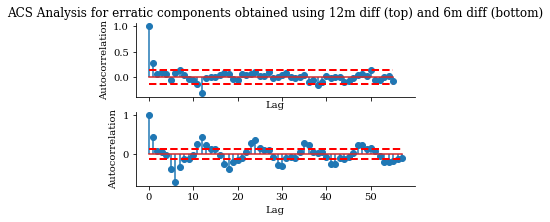

In [145]:
plt.rcParams['figure.figsize'] = (5, 3)

fig, axs=plt.subplots(2, 1, sharex=True)
# fig.title('ACS Analysis for erratic components obtained using 12m diff (top) and 6m diff (bottom)')

# No trend-1st order diff and no seasonality (seas. diff)
ts12 = tsTrain.diff().diff(12)
ts12.name = 'No trend + No Seasonality (12m cycle)'

N=ts12.dropna().size

corrl = correlogram(ts12.dropna(), maxT=int(N/4))
corrl.name='CPI ACS (No trend + No Seasonality (12m cycle))'
axs[0].stem(corrl.index, corrl['ACS'], use_line_collection=True)
axs[0].plot(corrl.index, corrl['upsig'], linestyle='--', color='r', linewidth=2)
axs[0].plot(corrl.index, corrl['dnsig'], linestyle='--', color='r', linewidth=2)
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Autocorrelation')
axs[0].set_title('ACS Analysis for erratic components obtained using 12m diff (top) and 6m diff (bottom)')

# No trend-1st order diff and no seasonality (12m + 6m)
ts6 = tsTrain.diff().diff(6)
ts6.name = 'No trend + No Seasonality (6m cycle)'

N=ts6.dropna().size
corrl = correlogram(ts6.dropna(), maxT=int(N/4))
corrl.name='CPI ACS (No trend + No 6-month cycle)'
axs[1].stem(corrl.index,corrl['ACS'], use_line_collection=True)
axs[1].plot(corrl.index,corrl['upsig'], linestyle='--', color='r', linewidth=2)
axs[1].plot(corrl.index,corrl['dnsig'], linestyle='--', color='r', linewidth=2)
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Autocorrelation')

# plt.legend(['No trend + No Seasonality (12m cycle)', 'No trend + No Seasonality (6m cycle)'])
plt.show()

#### 4.4 - Stationarity

A process is said to be WSS if the mean and autocorrelation/autocovariance functions are not dependent on the time that they are computed, i.e., if first and second-order statistical moments are constant along time. In common words, we say that a process is WSS if the mean and variance with (auto-covariance for $T=0$) are constant with time.

In [89]:
def meanvarWtime(timeseries, W = 2):
    Nwin = int(np.floor(timeseries.size / W))
    vals = timeseries.to_numpy()
    vals = vals[0: int(Nwin * W)]
    mvals = vals.reshape((Nwin, W))
    return {
	  'mu': np.mean(mvals, axis=1),
	  'var': np.var(mvals, axis=1)
	}

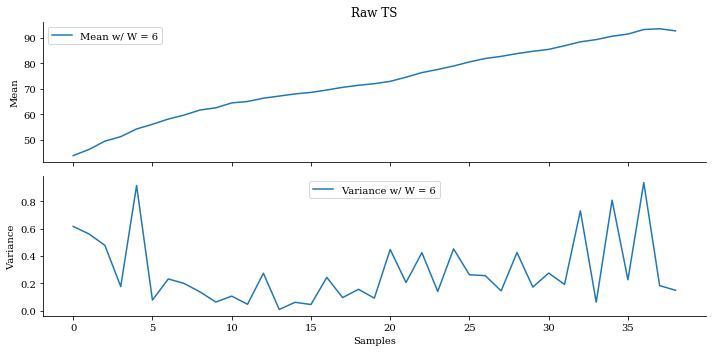

In [90]:
fig, axs=plt.subplots(
	2, tight_layout=True, sharex=True)

Win = 6
meanpsTSSeries = meanvarWtime(tsTrain, W=Win)['mu']
meanTS = pd.Series(
	data=meanpsTSSeries,
	index=np.array(range(meanpsTSSeries.size)),
	name=f'Mean w/ W = {Win}'
)
meanTS.plot(
	ax=axs[0], 
	title='Raw TS',
	xlabel='Samples', 
	ylabel='Mean', 
	legend=True
)

varpsTSSeries = meanvarWtime(tsTrain, W=Win)['var']
varTS = pd.Series(
	data=varpsTSSeries,
	index=np.array(range(varpsTSSeries.size)),
	name=f'Variance w/ W = {Win}'
)
varTS.plot(
	ax=axs[1],
	xlabel='Samples',
	ylabel='Variance',
	legend=True
)

plt.show()

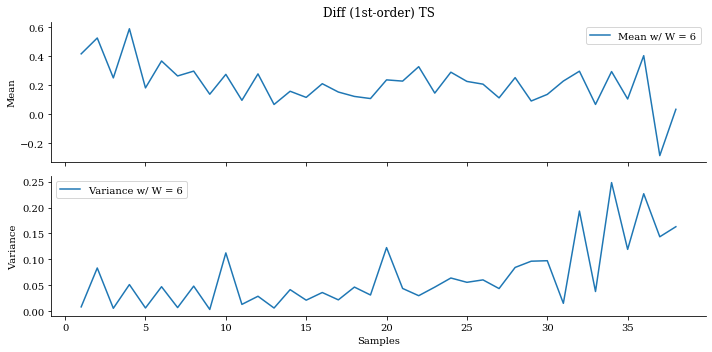

In [91]:
fig, axs=plt.subplots(
	2, tight_layout=True, sharex=True)

d1psTS=tsTrain.diff()

meanpsTSSeries = meanvarWtime(d1psTS, W=Win)['mu']
meanTS = pd.Series(
	data=meanpsTSSeries,
	index=np.array(range(meanpsTSSeries.size)),
	name=f'Mean w/ W = {Win}'
)
meanTS.plot(
	ax=axs[0], 
	title='Diff (1st-order) TS',
	xlabel='Samples', 
	ylabel='Mean', 
	legend=True
)

varpsTSSeries = meanvarWtime(d1psTS, W=Win)['var']
varTS = pd.Series(
	data=varpsTSSeries,
	index=np.array(range(varpsTSSeries.size)),
	name=f'Variance w/ W = {Win}'
)
varTS.plot(
	ax=axs[1],
	xlabel='Samples',
	ylabel='Variance',
	legend=True
)

plt.show()

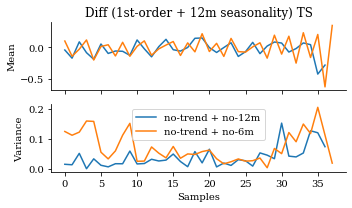

In [148]:
plt.rcParams['figure.figsize'] = (5, 3)


fig, axs=plt.subplots(
	2, tight_layout=True, sharex=True)

d1ps = tsTrain.diff()
d1psTS=tsTrain.diff().diff(12)
d1psTS_2=tsTrain.diff().diff(6)
d1psTS_3=tsTrain.diff().diff(6).diff(12)

d1ps = d1ps.dropna()
d1psTS = d1psTS.dropna()
d1psTS_2 = d1psTS_2.dropna()

meanpsTSSeries = meanvarWtime(d1psTS, W=Win)['mu']
meanTS = pd.Series(
	data=meanpsTSSeries,
	index=np.array(range(meanpsTSSeries.size)),
	name='no-trend + no-12m'
)
meanTS.plot(
	ax=axs[0], 
	title='Diff (1st-order + 12m seasonality) TS',
	xlabel='Samples', 
	ylabel='Mean', 
)

varpsTSSeries = meanvarWtime(d1psTS, W=Win)['var']
varTS = pd.Series(
	data=varpsTSSeries,
	index=np.array(range(varpsTSSeries.size)),
	name='no-trend + no-12m'
)
varTS.plot(
	ax=axs[1],
	xlabel='Samples',
	ylabel='Variance',
	legend=True
)

meanpsTSSeries_2 = meanvarWtime(d1psTS_2, W=Win)['mu']
meanTS_2 = pd.Series(
	data=meanpsTSSeries_2,
	index=np.array(range(meanpsTSSeries_2.size)),
	name='no-trend + no-6m'
)
meanTS_2.plot(
	ax=axs[0], 
	xlabel='Samples', 
	ylabel='Mean', 
)

varpsTSSeries_2 = meanvarWtime(d1psTS_2, W=Win)['var']
varTS_2 = pd.Series(
	data=varpsTSSeries_2,
	index=np.array(range(varpsTSSeries_2.size)),
	name='no-trend + no-6m'
)
varTS_2.plot(
	ax=axs[1],
	xlabel='Samples',
	ylabel='Variance',
	legend=True
)

# meanpsTSSeries_3 = meanvarWtime(d1psTS_3, W=Win)['mu']
# meanTS_3 = pd.Series(
# 	data=meanpsTSSeries_3,
# 	index=np.array(range(meanpsTSSeries_3.size)),
# 	name='no-trend + no-6m + no-12m'
# )
# meanTS_3.plot(
# 	ax=axs[0], 
# 	title=f'Diff no-trend no-12m vs no-trend no-6m vs no-trend no-6m no-12m TS (W={Win})',
# 	xlabel='Samples', 
# 	ylabel='Mean', 
# 	legend=True
# )

# varpsTSSeries_3 = meanvarWtime(d1psTS_3, W=Win)['var']
# varTS_3 = pd.Series(
# 	data=varpsTSSeries_3,
# 	index=np.array(range(varpsTSSeries_3.size)),
# 	name='no-trend + no-12m + no-6m'
# )
# varTS_3.plot(
# 	ax=axs[1],
# 	xlabel='Samples',
# 	ylabel='Variance',
# 	legend=True
# )

plt.show()

In [93]:
# fig, axs=plt.subplots(
# 	2, tight_layout=True, sharex=True)

# d1psTS_2=tsTrain.diff().diff(6).diff(12)

# meanpsTSSeries_2 = meanvarWtime(d1psTS_2, W=Win)['mu']
# meanTS_2 = pd.Series(
# 	data=meanpsTSSeries_2,
# 	index=np.array(range(meanpsTSSeries_2.size)),
# 	name=f'Mean w/ W = {Win}'
# )
# meanTS_2.plot(
# 	ax=axs[0], 
# 	title='Diff (1st-order + 12m seasonality + 6m seasonality) TS',
# 	xlabel='Samples', 
# 	ylabel='Mean', 
# 	legend=True
# )

# varpsTSSeries_2 = meanvarWtime(d1psTS_2, W=Win)['var']
# varTS_2 = pd.Series(
# 	data=varpsTSSeries_2,
# 	index=np.array(range(varpsTSSeries_2.size)),
# 	name=f'Variance w/ W = {Win}'
# )
# varTS_2.plot(
# 	ax=axs[1],
# 	xlabel='Samples',
# 	ylabel='Variance',
# 	legend=True
# )

# plt.show()

For a window of 6 and given the plots for both 12m and 6m seasonalities, we can infer that the erratic component produced by the removal of the 6m (2 cycle/year) pattern seems **less** stationary than the 12m-only one. The mean+variance on the 12m+6m have more oscillation over time, and the 6m has higher overall variance values. It's important to note that increases in the window value (12, 18 and 24) corroborate these results.

We can also use a statistical test - Augmented Dickey-Fuller Test, or ADF for short - to further test the stationarity of the resulting erratic component.

In [112]:
import statsmodels.tsa.stattools as st

def adf(seriesName, ts) -> None:
    adfStatistic,  \
    pValue, \
    _, _, \
    criticalValues, _ = st.adfuller(ts)
    print(
        f'''
        Series Name: {seriesName}
        ADF Statistic: {adfStatistic},
        p-value: {pValue} -> TS is {'' if pValue < 0.05 else 'non-'}stationary,
        Critical Values: {criticalValues}
        '''
    )

adf('Raw TS', tsTrain)
adf("No-trend TS (1st-order)", tsTrain.diff().dropna())
adf("No-trend and no-12m seasonal pattern TS", tsTrain.diff().diff(12).dropna())
adf("No-trend and no-6m seasonal pattern TS" , tsTrain.diff().diff(6).dropna())



        Series Name: Raw TS
        ADF Statistic: -1.637673358168196,
        p-value: 0.46347678776366397 -> TS is non-stationary,
        Critical Values: {'1%': -3.4602906385073884, '5%': -2.874708679520702, '10%': -2.573788599127782}
        

        Series Name: No-trend TS (1st-order)
        ADF Statistic: -1.8207073704601753,
        p-value: 0.3702305953163878 -> TS is non-stationary,
        Critical Values: {'1%': -3.4602906385073884, '5%': -2.874708679520702, '10%': -2.573788599127782}
        

        Series Name: No-trend and no-12m seasonal pattern TS
        ADF Statistic: -4.659103799661015,
        p-value: 0.00010036908232896367 -> TS is stationary,
        Critical Values: {'1%': -3.4620315036789666, '5%': -2.8754705024827127, '10%': -2.5741950726860647}
        

        Series Name: No-trend and no-6m seasonal pattern TS
        ADF Statistic: -9.142265498572781,
        p-value: 2.828460549615408e-15 -> TS is stationary,
        Critical Values: {'1%': -3.460